# Add labels to DB
For every _valid_ experiment, add labels to a separate table.
We use the following labels:
- scaled MS responses for all products
- binary outcome for all products
- major product (A, B, C, or no_product)

We use the methods for scaling that were established in the exploratory data analysis.

## Scaling the LCMS responses
- It seems to make sense to use some kind of robust scaling as we definitely expect outliers in LCMS data.
- We do not require centering, as the data starts at 0 and is not normally distributed.
- We could divide by the interquartile range (IQR) to get a robust scaling.
- We could also use the median absolute deviation (MAD) to get a robust scaling.
- However, both above ideas seem more suitable for symmetric distributions, while we have a highly skewed distribution with a defined minimum at 0.
- Therefore, we could just divide by, say, the 90th percentile to get the equivalent of min-max scaling but robust to outliers.
- Which percentile we choose, depends on the number of outliers we expect. The 90th percentile seems reasonable as we already remove internal standard errors and we can expect less than 10% of compounds to be outliers by virtue of ionizability alone. At the same time, choosing the 90th means we expect all products to form in at least 10% of the reactions.
- To not be dependent on how often a product forms: Use a lower (say 80th) percentile, but use only non-zero values in calculating the percentile.

### An extension to the scaling idea
Assume we have achieved robust scaling. There remains a problem:
- Consider product A systematically ionizes 10 times better than product B.
- Further, consider a reaction where we measure a non-zero response for product A that is at the lower detection limit
- It follows that we have no way to tell whether product B was formed or not, we only know it was not formed 10 times as much as A.

In general, if product A ionized better than product B by a factor of x, we need to see a response for product A exceeding the lower detection limit by a factor of x to conclude that product A is the major product.


In [1]:
from typing import Tuple, Union
import pathlib
import sys

sys.path.append(str(pathlib.Path().resolve().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.util.db_utils import SynFermDatabaseConnection

In [2]:
con = SynFermDatabaseConnection()

In [3]:
data = con.con.execute("SELECT * FROM experiments").fetchall()
df = pd.DataFrame(data, columns=[c[1] for c in con.con.execute("PRAGMA table_info(experiments)").fetchall()])
len(df)

58664

In [4]:
df = df.loc[(~df["valid"].str.contains("ERROR", na=False)) & (df["exp_nr"].between(4, 29))].copy()  # kick out invalid experiments

In [5]:
len(df)

40389

In [6]:
def robust_scale(x: np.ndarray, percentile: int = 75, return_scaling_factor=False) -> Union[np.ndarray, Tuple[np.ndarray, float]]:
    """
    Robust scaling of a numpy array by dividing by the value for a percentile.
    The percentile is calculated from all non-zero values.
    """
    x = x.copy()
    scaling_factor = np.percentile(x[x > 0], percentile)
    x /= scaling_factor
    if return_scaling_factor:
        return x, scaling_factor
    else:
        return x

In [7]:
# before we apply scaling, we need to verify how sensitive the scaling is to our choice of the percentile.
factors = []
for percentile in range(1, 100):
    scaled_arrs = []
    scaling_factors = []
    for s in "ABCDEFGH":
        arr, factor = robust_scale(df[f'product_{s}_lcms_ratio'].values, percentile=percentile, return_scaling_factor=True)
        scaled_arrs.append(arr)
        scaling_factors.append(factor)
    factors.append(scaling_factors / scaling_factors[0])

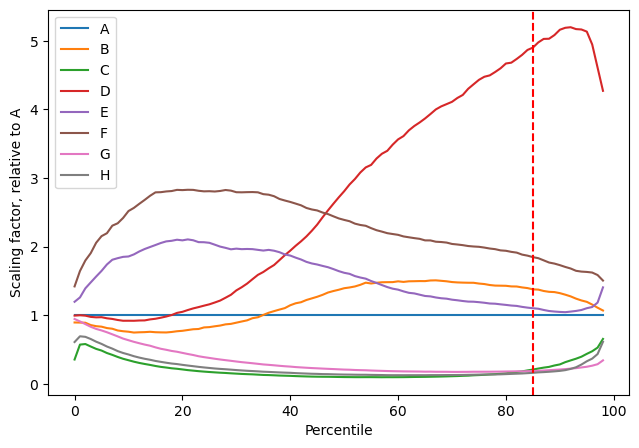

In [8]:
# plot the relative scaling factors for each product (A is always 1) for all percentiles between [1, 99]
plt.figure(figsize=(7.5,5))
plt.plot(factors)
plt.xlabel("Percentile")
plt.ylabel("Scaling factor, relative to A")
plt.axvline(85, color="red", linestyle="--", label="85th")
plt.legend("ABCDEFGH")


### Result of the percentile/scaling factor analysis
This outcome is good. The range of the scaling factors is mostly 2x - 3x. This seems reasonable given that the molecules always share quite a few residues. Also, except product D, all relative factors are quite stable w.r.t. the choice of percentile. In particular, relative A,B,C are stable. As we expect, in the very high percentiles (>95 for most, >90 for E), the scaling factor becomes unstable as it is now dominated by outliers.

**Based on the plot, we choose the 85th percentile**

In [9]:
# apply scaling to all products and show scaling factors for control
scaling_factors = []
for s in "ABCDEFGH":
        arr, factor = robust_scale(df[f'product_{s}_lcms_ratio'].values, percentile=85, return_scaling_factor=True)
        df[f'scaled_{s}'] = arr
        scaling_factors.append(factor)
print("Scaling factors relative to A:")
for s, i in zip("ABCDEFGH", scaling_factors):
    print(f"{s}: {i/scaling_factors[0]:.1f}")

Scaling factors relative to A:
A: 1.0
B: 1.4
C: 0.2
D: 4.9
E: 1.1
F: 1.9
G: 0.2
H: 0.2


In [10]:
df

,id,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,...,vl_id,valid,scaled_A,scaled_B,scaled_C,scaled_D,scaled_E,scaled_F,scaled_G,scaled_H
3928,10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,...,201048,WARNING: heating failure on first step; WARNIN...,2.430935,1.277949,0.285254,0.000000,0.413053,0.232611,5.452566,0.290557
3929,10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,...,201062,WARNING: heating failure on first step; WARNIN...,0.382317,0.926318,0.240020,0.000000,0.064906,0.339427,5.693844,0.000000
3930,10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,...,201053,WARNING: heating failure on first step; WARNIN...,0.931135,0.867479,0.042005,0.000000,0.000000,0.291865,5.596290,0.000000
3931,10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,...,201057,WARNING: heating failure on first step; WARNIN...,2.138999,2.543982,0.074154,0.000830,0.283941,0.321137,6.585098,0.213757
3934,10584,5,4,A9,JG255,2021-08-17,I67,M20,T1,Ph023,...,201024,WARNING: heating failure on first step,2.400752,0.011716,0.000000,0.001561,0.209155,1.204209,7.226035,0.811754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55186,85516,4,3,P4,JG248,2021-07-15,I33,M22,T32,Al038,...,97981,WARNING: multiple peaks for product A (3),0.434870,0.408621,0.049184,0.837999,0.221545,0.113867,0.239900,0.587401
55187,85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,...,97980,WARNING: multiple peaks for product A (3),2.600142,0.579447,0.272896,2.550658,2.623485,0.075989,0.361729,2.735786
55188,85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,...,97989,WARNING: multiple peaks for product A (3),0.193778,0.189502,0.000000,0.424259,0.159489,0.231678,0.476966,0.096510
55189,85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,...,97969,None,0.686007,0.217935,0.089747,0.998466,0.326363,0.159827,0.374399,0.591288


In [11]:
# add binary outcome: 1 if product was formed, 0 if not
df["binary_A"] = (df["scaled_A"] > 0).astype(int)
df["binary_B"] = (df["scaled_B"] > 0).astype(int)
df["binary_C"] = (df["scaled_C"] > 0).astype(int)
df["binary_D"] = (df["scaled_D"] > 0).astype(int)
df["binary_E"] = (df["scaled_E"] > 0).astype(int)
df["binary_F"] = (df["scaled_F"] > 0).astype(int)
df["binary_G"] = (df["scaled_G"] > 0).astype(int)
df["binary_H"] = (df["scaled_H"] > 0).astype(float)
df.loc[df["scaled_H"].isna(), "binary_H"] = pd.NA

In [12]:
df.describe()

,id,exp_nr,plate_nr,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,product_D_lcms_ratio,product_E_lcms_ratio,product_F_lcms_ratio,product_G_lcms_ratio,...,scaled_G,scaled_H,binary_A,binary_B,binary_C,binary_D,binary_E,binary_F,binary_G,binary_H
count,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,...,40389.000000,37046.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,40389.000000,37046.000000
mean,55236.411498,17.094333,3.509891,0.063089,0.056637,0.007229,0.275964,0.085048,0.133278,0.016182,...,0.575268,0.691375,0.814331,0.572334,0.283320,0.809305,0.857734,0.925995,0.860408,0.528019
std,19519.604357,7.675378,1.701237,0.119841,0.120039,0.046570,0.558628,0.193360,0.285546,0.042791,...,1.521186,9.276075,0.388844,0.494746,0.450616,0.392854,0.349328,0.261783,0.346568,0.499221
min,10578.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42255.000000,10.000000,2.000000,0.001331,0.000000,0.000000,0.001184,0.004189,0.010744,0.001331,...,0.047320,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,57663.000000,17.000000,4.000000,0.014903,0.001653,0.000000,0.025492,0.033265,0.058134,0.004449,...,0.158159,0.025104,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,70207.000000,24.000000,5.000000,0.072342,0.057620,0.000660,0.290146,0.095507,0.172673,0.013523,...,0.480734,0.182979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,85520.000000,29.000000,6.000000,1.747482,1.885098,1.768702,30.935151,6.531743,25.884691,1.075001,...,38.215392,1043.819217,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.scaled_H.isna().sum()

3343

In [14]:
# assign the main product
df["main_product"] = df[["scaled_A", "scaled_B", "scaled_C"]].idxmax(axis=1).str.replace("scaled_", "")
# are there any reactions where neither A,nor B, nor C appear?
df.loc[df[["scaled_A", "scaled_B", "scaled_C"]].sum(axis=1) == 0, "main_product"] = "no_product"
df

,id,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,...,scaled_H,binary_A,binary_B,binary_C,binary_D,binary_E,binary_F,binary_G,binary_H,main_product
3928,10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,...,0.290557,1,1,1,0,1,1,1,1.0,A
3929,10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,...,0.000000,1,1,1,0,1,1,1,0.0,B
3930,10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,...,0.000000,1,1,1,0,0,1,1,0.0,A
3931,10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,...,0.213757,1,1,1,1,1,1,1,1.0,B
3934,10584,5,4,A9,JG255,2021-08-17,I67,M20,T1,Ph023,...,0.811754,1,1,0,1,1,1,1,1.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55186,85516,4,3,P4,JG248,2021-07-15,I33,M22,T32,Al038,...,0.587401,1,1,1,1,1,1,1,1.0,A
55187,85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,...,2.735786,1,1,1,1,1,1,1,1.0,A
55188,85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,...,0.096510,1,1,0,1,1,1,1,1.0,A
55189,85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,...,0.591288,1,1,1,1,1,1,1,1.0,A


In [15]:
with con.con:
    con.con.executemany('INSERT INTO labels (experiment_id, scaled_A, scaled_B, scaled_C, scaled_D, scaled_E, scaled_F, scaled_G, scaled_H, binary_A, binary_B, binary_C, binary_D, binary_E, binary_F, binary_G, binary_H, "major_A-C") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);',
                        df[["id", "scaled_A", "scaled_B", "scaled_C", "scaled_D", "scaled_E", "scaled_F", "scaled_G", "scaled_H", "binary_A", "binary_B", "binary_C", "binary_D", "binary_E", "binary_F", "binary_G", "binary_H", "main_product"]].values.tolist()
                        )